In [182]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import os
import numpy as np
import matplotlib.dates as mdates
from numpy.linalg import inv

We want to find a such that the annual volatility of $R_{FUND} = R_{T_{Bill}}(1-a) + aR_{DIV}$ is 15%. Hence, since T-bills are considered as risk-free and the DIV annual standard deviation is known from 3c: 

$\sigma(R_{FUND}) = a\sigma(R_{DIV}) = 15\% \implies a = \frac{0,15}{\sigma(R_{DIV})}.$  

Note that we will not short the DIV portfolio as the average return is positive, so the only negative option of a is not taken into account.

In [183]:
# Q8.1
div_return = pd.read_csv("data/q3/div_return.csv").set_index("date")
div_std = np.sqrt(12)*div_return["DIV_return"].std()
a = 0.15/div_std

print(f"The average value of a is : {a}")


The average value of a is : 1.072346248926775


In [184]:
# Q8.2 
# import MOM, REV, CARRY, DOLLAR, and risk-free
mom_ret_df = pd.read_csv("data/q4/mom_return.csv")
rev_ret_df = pd.read_csv("data/q5/rev_return.csv")
carry_ret_df = pd.read_csv("data/q6/carry_returns.csv")
dollar_ret_df = pd.read_csv("data/q7/USD_vs_World.csv")
risk_free = pd.read_csv('data/preprocess/tbills.csv').set_index("date")

# Merge them in 1 dataframe
returns_df = mom_ret_df.merge(rev_ret_df, on="date", how='inner').merge(carry_ret_df, on="date", how='inner').merge(dollar_ret_df, on="date",how='inner')
returns_df = returns_df.set_index("date")

# Re-create a dataframe with the values of R_fund with DIV only
to_align = div_return.index.intersection(risk_free.index)
div_strategy = div_return.loc[to_align].mul(a).values + risk_free.loc[to_align].mul(1-a).values
df_div_final = pd.DataFrame(div_strategy, columns=["DIV Only"], index=to_align)


In [185]:
# q8.3
# Adapted risk-free parity calculation method
def risk_parity_strat(returns: pd.DataFrame, rf_series: pd.Series):
    # Volatiliy shifted by 1 to match returns on time t with std until t-1 
    rolling_vol = returns.rolling(window=60).std().shift(1).dropna()
    inv_vol = 1 / rolling_vol
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0).dropna()
    returns_aligned = returns.loc[weights.index]
    return_b = (weights * returns_aligned).sum(axis=1).dropna()
    mean_b = 12*return_b.mean()
    std_b = np.sqrt(12)*return_b.std()
    sharpe_b = (mean_b ) / std_b

    print("RISK-PARITY FOR R_strat : ")
    print(f"Mean return : {mean_b}")
    print(f"Standard deviation : {std_b}")
    print(f"Sharpe ratio : {sharpe_b}")

    return return_b.to_frame().rename(columns={0:"STRAT_return"}), weights

In [186]:
#Q8.c
# Calculate R_strat
ret_strat, weights_strat = risk_parity_strat(returns_df, risk_free["rf"])

RISK-PARITY FOR R_strat : 
Mean return : 0.18170332608873474
Standard deviation : 0.04700321383261913
Sharpe ratio : 3.8657638759721764


In [187]:
#Q8.c
# Adapted mean-variance calculation  method 
def mean_variance(returns: pd.DataFrame):
    rolling_mean = returns.rolling(window=60).mean().dropna()
    rolling_cov = returns.rolling(window=60).cov().dropna()

    mv_weights = []
    dates_mv = rolling_mean.index
    columns = returns.columns

    for date in dates_mv:
        mu = rolling_mean.loc[date]
        Sigma = rolling_cov.loc[date]
        w = inv(Sigma) @ mu
        mv_weights.append(w)


    mv_weights_df = pd.DataFrame(mv_weights, index=dates_mv, columns=columns)
    returns_aligned_mv = returns.loc[mv_weights_df.index]
    weighted_returns = mv_weights_df * returns_aligned_mv
    return_c = (weighted_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE BEFORE NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} \n")

    new_weights = mv_weights_df.multiply(0.15/std_c)
    new_returns = new_weights*returns_aligned_mv
    return_c = (new_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE AFTER NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} \n")

    return return_c, new_weights


In [188]:
# Q8.c
# Calculate the weights b and c

# Substract the monthly T-bill return to the DIV strategy return to get excess return
rf_df = risk_free
div_rf = div_return
common_index = div_rf.index.intersection(rf_df.index)
div_common = div_rf.loc[common_index]
rf_common = rf_df.loc[common_index]
result = pd.DataFrame(
    div_common.values - rf_common.values,
    index=common_index,
    columns=div_rf.columns
)

# Apply mean-variance and get weights b and c
fund_ret = pd.merge(result, ret_strat, left_index=True, right_index=True)
ret_fund, weights_ret = mean_variance(fund_ret)

print(f"The average value of b is : {weights_ret["DIV_return"].mean()}")
print(f"The average value of c is : {weights_ret["STRAT_return"].mean()}")





MEAN-VARIANCE BEFORE NORMALIZING : 
Mean return : 22.061329216771007
Standard deviation : 4.373458404761102
Sharpe ratio : 5.04436699175057 

MEAN-VARIANCE AFTER NORMALIZING : 
Mean return : 0.7566550487625853
Standard deviation : 0.15
Sharpe ratio : 5.044366991750569 

The average value of b is : 0.3717175514274233
The average value of c is : 3.2359368476543358


In [189]:
# Q8.c 
# Calculate the weights of each fund by multiplying c by each weight in STRAT
# T-Bill weight = 1-b

final_weights = weights_strat.mul(weights_ret["STRAT_return"], axis=0).dropna()
final_weights["TBILL"] = 1-weights_ret["DIV_return"]
final_weights["DIV"] = weights_ret["DIV_return"]

final_weights


,MOM,REV,CARRY,DOLLAR,TBILL,DIV
date,,,,,,
2017-05-01,0.514848,0.622886,0.717127,0.859978,0.860293,0.139707
2017-06-01,0.503124,0.607345,0.702738,0.852697,0.788182,0.211818
2017-07-01,0.503527,0.611171,0.720224,0.869842,0.790452,0.209548
2017-08-01,0.511307,0.616572,0.765585,0.880912,0.801370,0.198630
2017-09-01,0.544441,0.655462,0.819226,0.946967,0.821466,0.178534
...,...,...,...,...,...,...
2024-08-01,0.569999,0.659335,0.617338,0.821261,0.506124,0.493876
2024-09-01,0.571428,0.663335,0.614026,0.816903,0.505146,0.494854
2024-10-01,0.563485,0.657021,0.601764,0.800556,0.511728,0.488272


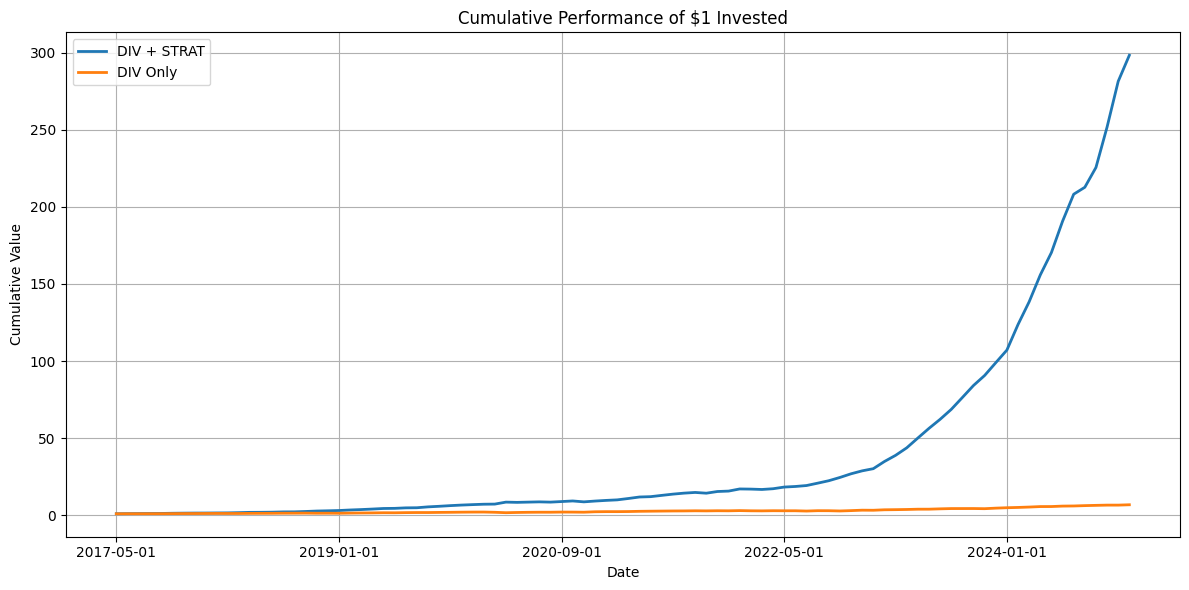

In [190]:
#Q8.d 
# Plot the cumulative performance of both DIV-only and DIV+STRAT fund strategies

df_strat, df_benchmark = ret_fund.align(df_div_final, join='inner')
# Add back the risk-free rate to the second FUND strategy 
df_final_strat =  risk_free.loc[df_strat.index]["rf"] + df_strat
cum_strat = (1 + df_final_strat).cumprod()
cum_benchmark = (1 + df_benchmark).cumprod()
plt.figure(figsize=(12, 6))
cum_strat.plot(ax=plt.gca(), label='DIV + STRAT', linewidth=2)
cum_benchmark.plot(ax=plt.gca(), label='DIV Only', linewidth=2)

plt.title('Cumulative Performance of $1 Invested')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [191]:
#Q8.d 
# Calculate the mean, std and Sharpe ratio of the DIV only strategy
mean = 12*df_div_final["DIV Only"].mean()
std = np.sqrt(12)*df_div_final["DIV Only"].std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV Only : ")
print(f"Mean return : {mean}")
print(f"Standard deviation : {std}")
print(f"Sharpe ratio : {sharpe}")

DIV Only : 
Mean return : 0.1141347626212183
Standard deviation : 0.14995185614597586
Sharpe ratio : 0.6612871341380505


In [192]:
# Q8.d
# Calculate the mean, std and Sharpe ratio of the DIV+STRAT strategy
mean = 12*df_final_strat.mean()
std = np.sqrt(12)*df_final_strat.std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV + STRAT : ")
print(f"Mean = {mean}")
print(f"Standard deviation : {std}")
print(f"Sharpe Ratio : {sharpe}")

DIV + STRAT : 
Mean = 0.7776550487625855
Standard deviation : 0.15319767471111892
Sharpe Ratio : 4.978414462158062
